In [ ]:
import os 

#sys.path.insert(0,"/homes/o23gauvr/Documents/thèse/code/FASCINATION/")
running_path = "/homes/o23gauvr/Documents/thèse/code/FASCINATION/"
os.chdir(running_path)

In [ ]:


import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import hydra
import pickle
from src.utils import get_cfg_from_ckpt_path 
from src.select_outputs_on_params import select_outputs_on_params
from sklearn.decomposition import PCA
import numpy as np
import scipy.ndimage
from tqdm import tqdm
from pathlib import Path
import re
from src.utils import *


In [2]:
plt.style.use('ggplot')

In [3]:
cmap = plt.get_cmap('viridis')

In [4]:
gpu = None
    
if torch.cuda.is_available() and gpu is not None:
##This may not be necessary outside the notebook
    dev = f"cuda:{gpu}"
else:
    dev = "cpu"

device = torch.device(dev)

In [5]:
try:
    if dm_dict:
        print("Not reloading datamodule")

except:
    
    dm_dict = {}
    n_components = 0
    print("Initializing datamodule")

Initializing datamodule


In [6]:
save_fig = False

In [7]:
load_pca = True

In [8]:
norm = False

In [9]:
if load_pca:
    with open(f"pickle/rmse_ssp_pca_on_dm_3D_norm_{norm}.pkl", "rb") as file:
        pca_ssp_rmse_dict = pickle.load(file)  
        
    with open(f"pickle/rmse_ecs_pca_on_dm_3D_norm_{norm}.pkl", "rb") as file:
        pca_ecs_rmse_dict = pickle.load(file)  


else:
    pca_ssp_rmse_dict = {}
    pca_ecs_rmse_dict = {}
    

# Functions

In [10]:
# def explicit_ecs_1D(ssp: torch.tensor,
#                     depth_tens: torch.tensor,
#                     tau = 100):
    
#     ssp = ssp.unsqueeze(1).nan_to_num()          # This operation might be unnecessary if ssp already has the correct shape
#     kernel = torch.tensor([-1.0, 1.0]).float().view(1, 1, 2).to(ssp.device)
#     derivative = F.conv1d(ssp, kernel, padding=0)

#     sign = torch.sign(derivative) + F.tanh(tau * derivative) - F.tanh(tau * derivative).detach()

#     sign_diff = F.conv1d(sign, kernel, padding=1)
#     sign_change = F.tanh(10 * F.relu(-sign_diff))

#     for pattern in ([1, 0, 1], [1, -1, 0, 0]):
#         n = len(pattern)
#         kernel_matrix = torch.eye(n)
#         element_match = 0
#         for i in range(n):
#             kernel_element = kernel_matrix[i, :].view(1, 1, n).to(ssp.device)
#             element_match += (F.conv1d(sign, kernel_element, padding=0) - pattern[i]) ** 2

#         # Adjust padding to match the length of sign_change
#         pattern_recognition = F.pad(element_match, (1, sign_change.shape[2] - element_match.shape[2] - 1), value=1.0)
#         mask_discontinuity = 1 - F.relu(pattern_recognition + 1) * F.relu(1 - pattern_recognition)

#         sign_change = sign_change * mask_discontinuity

#     mask = F.relu(2 - torch.cumsum(sign_change, dim=2))

#     # Expand and align depth_array with the reduced shape of the input tensor
     
#     depth_array_tens = depth_tens[:mask.shape[2]].view(1,-1).to(ssp.device).type(sign_change.dtype)
#     depth_array_tens[0, 0] = 0.0  # TODO: Handle the first depth value properly

#     ecs_pred = (sign_change * mask).squeeze(dim=1)
#     ecs_pred = (ecs_pred * depth_array_tens).max(dim=1).values
#     return ecs_pred



In [11]:
# def explicit_ecs_2D(ssp: torch.tensor,
#                     depth_tens: torch.tensor,
#                     batch: bool = False,
#                     tau = 100):
    
#     if batch:
#         ssp = ssp.unsqueeze(1).nan_to_num()  
    
#     else:
#         ssp = ssp.unsqueeze(0).unsqueeze(0).nan_to_num()  
        
#     kernel = torch.tensor([-1.0, 1.0]).float().view(1, 1, 2, 1).to(ssp.device)
#     derivative = F.conv2d(ssp, kernel, padding=0)

#     sign = torch.sign(derivative) + F.tanh(tau * derivative) - F.tanh(tau * derivative).detach()

#     sign_diff = F.conv2d(sign, kernel, padding=(1,0))
#     sign_change = F.tanh(10 * F.relu(-sign_diff))

#     for pattern in ([1, 0, 1], [1, -1, 0, 0]):
#         n = len(pattern)
#         kernel_matrix = torch.eye(n)
#         element_match = 0
#         for i in range(n):
#             kernel_element = kernel_matrix[i, :].view(1, 1, n, 1).to(ssp.device)
#             element_match += (F.conv2d(sign, kernel_element, padding=0) - pattern[i]) ** 2

#         # Adjust padding to match the length of sign_change
#         pattern_recognition = F.pad(element_match, (0,0,1, sign_change.shape[2] - element_match.shape[2] - 1), value=1.0)
#         mask_discontinuity = 1 - F.relu(pattern_recognition + 1) * F.relu(1 - pattern_recognition)

#         sign_change = sign_change * mask_discontinuity

#     mask = F.relu(2 - torch.cumsum(sign_change, dim=2))

#     # Expand and align depth_array with the reduced shape of the input tensor
     
#     depth_array_tens = depth_tens[:mask.shape[2]].view(1,-1, 1).to(ssp.device).type(sign_change.dtype)
#     depth_array_tens[0, 0] = 0.0  # TODO: Handle the first depth value properly

#     ecs_pred = (sign_change * mask).squeeze(dim=1)
#     ecs_pred = (ecs_pred * depth_array_tens).max(dim=1).values
    
#     if not batch:
#         ecs_pred = ecs_pred.squeeze(0)
        
#     return ecs_pred

# #ecs_2d = explicit_ecs_2D(torch.tensor(ssp_truth_unorm_test_arr[t,:,lat,:]).float(),torch.tensor(depth_array).float()).to(device) 



In [12]:
# def explicit_ecs_3D(ssp: torch.tensor,
#                     depth_tens: torch.tensor,
#                     batch: bool = False,
#                     tau = 100):
    
#     if batch:
#         ssp = ssp.unsqueeze(1).nan_to_num()  
    
#     else:
#         ssp = ssp.unsqueeze(0).unsqueeze(0).nan_to_num()       
        
#     kernel = torch.tensor([-1.0, 1.0]).float().view(1,1,2,1,1).to(ssp.device)
#     derivative = F.conv3d(ssp, kernel, padding=(0,0,0))

#     #sign = DF.differentiable_sign(derivative)

#     sign = torch.sign(derivative) + F.tanh(tau * derivative) - F.tanh(tau * derivative).detach()
#     #print("After torch.sign (sign):", sign.requires_grad, sign.grad_fn)


#     sign_diff = F.conv3d(sign, kernel, padding=(1,0,0))
#     sign_change = F.tanh(10*F.relu(-sign_diff))

#     for pattern in ([1, 0, 1], [1, -1, 0, 0]):  
#         n = len(pattern)
#         kernel_matrix = torch.eye(n)
#         element_match = 0
#         for i in range(n):
#             kernel_element = kernel_matrix[i,:].view(1,1,n,1,1).to(ssp.device)
#             element_match = element_match + (F.conv3d(sign, kernel_element, padding=(0,0,0)) - pattern[i])**2

#         pattern_recognition = F.pad( element_match, (0, 0, 0, 0, 1, (sign_change.shape[2]- element_match.shape[2]) - 1),value=1.)    



#         mask_discontinuity = 1 - F.relu(pattern_recognition+1) * F.relu(1-pattern_recognition)

#         sign_change = sign_change * mask_discontinuity


#     mask = F.relu(2 - torch.cumsum(sign_change, dim=2))

#     depth_array_tens = depth_tens[:mask.shape[2]].view(1,-1,1,1).to(ssp.device).type(sign_change.dtype)
#     depth_array_tens[0,0,0,0] = 0.  ##TODO the true first z value is equal to 48cm. It may have to be considered that way
#     ecs_pred = (sign_change * mask ).squeeze(dim=1)
#     ecs_pred = (ecs_pred * depth_array_tens).max(dim=1).values 
    
    
#     if batch:
#         ecs_pred = ecs_pred.squeeze(0)
        
#     return ecs_pred



# RMSE

In [13]:
# param_dict = {"model_name": "AE_CNN_3D",
#                 "channels_list": [[1,1], [1,1,1],[1,1,1,1], [1,1,1,1,1], [1,1,1,1,1,1]],
#                 "prediction_weight": 1,
#                 "gradient_weight": 10000,
#                 "n_conv_per_layer": 1,
#                 "padding": "linear",
#                 "interp_size": None,
#                 "pooling": ["Max", "None"],
#                 "pooling_dim": "all",
#                 "final_upsample_str": "upsample_pooling",
#                 "act_fn_str": "None",
#                 "final_act_fn_str": "None",
#                 "lr": 0.001,
#                 "normalization_method": "min_max",
#                 "manage_nan": "suppress",
#                 "n_profiles": None,  
#                 }

# output_path = "outputs/AE/AE_CNN_3D/"

# dir_to_ignore = ["[1,1]_trilinear_test_on_padding", "upsample_mode_test_on_[1,1]", "[1,1,2,2,4]_trilinear_test_on_padding"]
#ckpt_list = []
# ckpt_list = select_outputs_on_params(output_path, param_dict, dir_to_ignore)
#ckpt_list = list(Path().rglob('*.ckpt'))
#ckpt_list.extend(list(Path("outputs/AE/AE_CNN_3D/8_channels_spatial_pooling_with_pca_pre_treatment_bis").rglob('*.ckpt')))
ckpt_dict = {"spatial_pca_10":"outputs/AE/AE_CNN_3D/dataset_output/8_channels_spatial_pooling_with_pca_pre_treatment_bis/pred_0.5_grad_0_max_pos_0.8_max_value_0.1_fft_0.05_weighted_1_inflection_pos_0_inflection_value_0/depth_pre_treatment_pca_n_components_10",
             "spatial_pca_50":"outputs/AE/AE_CNN_3D/dataset_output/8_channels_spatial_pooling_with_pca_pre_treatment_bis/pred_0.5_grad_0_max_pos_0.8_max_value_0.1_fft_0.05_weighted_1_inflection_pos_0_inflection_value_0/depth_pre_treatment_pca_n_components_50",
             "spatial_pca_107":"outputs/AE/AE_CNN_3D/dataset_output/8_channels_spatial_pooling_with_pca_pre_treatment_bis/pred_0.5_grad_0_max_pos_0.8_max_value_0.1_fft_0.05_weighted_1_inflection_pos_0_inflection_value_0/depth_pre_treatment_pca_n_components_107",
             "spatial_complex_loss":"outputs/AE/AE_CNN_3D/dataset_output/8_channels_spatial_pooling/pred_0.01_grad_10000_max_pos_0.01_max_value_0.05_fft_0.05_weighted_1_inflection_pos_0.01_inflection_value_0.05",
             "spatial_basic_loss":"outputs/AE/AE_CNN_3D/dataset_output/8_channels_spatial_pooling/pred_1_grad_0_max_pos_0_max_value_0_fft_0_weighted_0_inflection_pos_0_inflection_value_0",}
             #"depth_complex_loss":"outputs/AE/AE_CNN_3D/dataset_output/8_channels_depth_pooling/pred_0.01_grad_10000_max_pos_0.01_max_value_0.05_fft_0.05_weighted_1_inflection_pos_0.01_inflection_value_0.05",
             #"depth_basic_loss":"outputs/AE/AE_CNN_3D/dataset_output/8_channels_depth_pooling/pred_1_grad_0_max_pos_0_max_value_0_fft_0_weighted_0_inflection_pos_0_inflection_value_0",
             #"all_complex_loss":"outputs/AE/AE_CNN_3D/dataset_output/8_channels_all_pooling/pred_0.01_grad_10000_max_pos_0.01_max_value_0.05_fft_0.05_weighted_1_inflection_pos_0.01_inflection_value_0.05",
             #"all_basic_loss":"outputs/AE/AE_CNN_3D/dataset_output/8_channels_all_pooling/pred_1_grad_0_max_pos_0_max_value_0_fft_0_weighted_0_inflection_pos_0_inflection_value_0"}

# ckpt_dict={"loss_1_pca_10":"outputs/AE/AE_CNN_3D/dataset_output/8_channels_spatial_pooling_with_pca_pre_treatment_bis/pred_0.2_grad_0_max_pos_1.5_max_value_1.1_fft_0_weighted_1_inflection_pos_0_inflection_value_0/depth_pre_treatment_pca_n_components_10",
#            "loss_1_pca_50":"outputs/AE/AE_CNN_3D/dataset_output/8_channels_spatial_pooling_with_pca_pre_treatment_bis/pred_0.2_grad_0_max_pos_1.5_max_value_1.1_fft_0_weighted_1_inflection_pos_0_inflection_value_0/depth_pre_treatment_pca_n_components_50",
#            "loss_1_pca_107":"outputs/AE/AE_CNN_3D/dataset_output/8_channels_spatial_pooling_with_pca_pre_treatment_bis/pred_0.2_grad_0_max_pos_1.5_max_value_1.1_fft_0_weighted_1_inflection_pos_0_inflection_value_0/depth_pre_treatment_pca_n_components_107",
#            "loss_2_pca_10":"outputs/AE/AE_CNN_3D/dataset_output/8_channels_spatial_pooling_with_pca_pre_treatment_bis/pred_0.5_grad_0_max_pos_0_max_value_0.1_fft_0_weighted_1_inflection_pos_0_inflection_value_0/depth_pre_treatment_pca_n_components_10",
#            "loss_2_pca_50":"outputs/AE/AE_CNN_3D/dataset_output/8_channels_spatial_pooling_with_pca_pre_treatment_bis/pred_0.5_grad_0_max_pos_0_max_value_0.1_fft_0_weighted_1_inflection_pos_0_inflection_value_0/depth_pre_treatment_pca_n_components_50",
#            "loss_2_pca_107":"outputs/AE/AE_CNN_3D/dataset_output/8_channels_spatial_pooling_with_pca_pre_treatment_bis/pred_0.5_grad_0_max_pos_0_max_value_0.1_fft_0_weighted_1_inflection_pos_0_inflection_value_0/depth_pre_treatment_pca_n_components_107",
#            "loss_3_pca_10":"outputs/AE/AE_CNN_3D/dataset_output/8_channels_spatial_pooling_with_pca_pre_treatment_bis/pred_0.5_grad_0_max_pos_0.8_max_value_0.1_fft_0.05_weighted_1_inflection_pos_0_inflection_value_0/depth_pre_treatment_pca_n_components_10",
#            "loss_3_pca_50":"outputs/AE/AE_CNN_3D/dataset_output/8_channels_spatial_pooling_with_pca_pre_treatment_bis/pred_0.5_grad_0_max_pos_0.8_max_value_0.1_fft_0.05_weighted_1_inflection_pos_0_inflection_value_0/depth_pre_treatment_pca_n_components_50",
#            "loss_3_pca_107":"outputs/AE/AE_CNN_3D/dataset_output/8_channels_spatial_pooling_with_pca_pre_treatment_bis/pred_0.5_grad_0_max_pos_0.8_max_value_0.1_fft_0.05_weighted_1_inflection_pos_0_inflection_value_0/depth_pre_treatment_pca_n_components_107"}

In [ ]:
verbose = True

ecs_algo = "max" #first_max

filtering = False
mode = "wrap"
best_median_kernel = 18




ae_rmse_dict = {"SSP":{},
                "ECS":{}}

if filtering:
    ae_rmse_dict["Filtered SSP"] = {}
    ae_rmse_dict["Filtered ECS"] = {}

        
for model_carac in ckpt_dict.keys():

    ckpt_list =  list(Path(ckpt_dict[model_carac]).rglob('*.ckpt'))


    for ckpt_path in tqdm(ckpt_list):
        ckpt_path = str(ckpt_path)
        
        model_name = " ".join((ckpt_path.split("AE")[-1]).split("/")).replace("_", "  ")
        print(f"\n{model_name}")
        
        # try:
        #     for carac in ckpt_path.split("/"):
        #         if "pred" in carac:
        #             weight = carac.replace("_", " ")
                    
        #     model_carac = re.search(r'AE/(.*?)/pred', ckpt_path).group(1).replace("_", " ").replace("/",": ") + f", {weight}"  
            
        # except:
        #     model_carac = re.search(r'AE/(.*?)/channels', ckpt_path).group(1).replace("_", " ").replace("/",": ")
            
        

        if model_carac not in ae_rmse_dict["SSP"].keys():
            for sub_dic in ae_rmse_dict.values():
                sub_dic[model_carac] = {}
        
        
        try:
            cfg = get_cfg_from_ckpt_path(ckpt_path, pprint = False)        
    
        except:
            print(f"Can't load model")
            continue
        
        
        if cfg.datamodule in list(dm_dict.keys()):
            dm = dm_dict[cfg.datamodule]
            test_ssp_arr, test_ssp_tens, _ = loading_datamodule_phase(dm, phase = "test")
        
        else:
            if verbose:
                print("Inititing datamodule; Generating train and test datasets")
            
            
            dm = hydra.utils.call(cfg.datamodule)  ##TODO this two lines take too long
            test_ssp_arr, test_ssp_tens, dm = loading_datamodule_phase(dm, phase = "test")
            dm_dict[cfg.datamodule] = dm
            
            # if not norm:
            #     test_ssp_arr = unorm_ssp_arr_3D(test_ssp_tens.detach().cpu().numpy(), dm, verbose = False)
            
            # ecs_truth = explicit_ecs_3D(torch.tensor(test_ssp_arr).float(),torch.tensor(depth_array).float(), batch = True).detach().cpu().numpy()

                
            if not load_pca:
                train_ssp_arr, _, _, _, _ = loading_datamodule_phase(dm, phase = "fit")
                input_train_shape = train_ssp_arr.shape
                
        
        
        input_test_shape = test_ssp_tens.shape
        depth_array = dm.depth_array


        
        if verbose:
            print("Loading model, generating AE output")      
        
        try:
            lit_model = load_model(ckpt_path, dm, device, verbose = True)    
        except:
            continue

        ssp_ae_test_arr = lit_model(test_ssp_tens).detach().cpu().numpy()
        
        # if not norm:
        #     ssp_ae_test_arr = unorm_ssp(ssp_ae_test_arr, dm, verbose = False)
            
        #ecs_pred_ae = explicit_ecs_3D(torch.tensor(ssp_ae_test_arr).float(),torch.tensor(depth_array).float(), batch = True).detach().cpu().numpy()
        
        # if ecs_max:
        #     indices_ecs_ae_max = ssp_ae_test_arr.argmax(axis=1)
        #     ecs_pred_ae_max = depth_array[indices_ecs_ae_max]
        #     ae_ecs_max_rmse = np.sqrt(np.mean((ecs_truth - ecs_pred_ae_max)**2))


        try:
            bottleneck_shape = lit_model.model_AE.bottleneck_shape
        except:
            bottleneck_shape = lit_model.encoder.net(test_ssp_tens.unsqueeze(1)).shape
            
        compression_rate_ae = test_ssp_tens.numel()/bottleneck_shape.numel()


        if bottleneck_shape[2] != n_components:

            n_components = bottleneck_shape[2]
            compression_rate_pca = 107/n_components
            
            if not load_pca:

                if verbose:
                    print("training PCA, generating PCA output")    
                    
                pca = PCA(n_components = n_components, svd_solver = 'auto')
                #pca.fit(train_ssp_arr.transpose(0,2,3,1).reshape(-1,107)) 

                if norm:
                    ssp_pca_test_arr =  pca.inverse_transform(pca.fit_transform(train_ssp_arr.transpose(0,2,3,1).reshape(-1, input_train_shape[1]))).reshape(input_train_shape[0],input_train_shape[2],input_train_shape[3],-1).transpose(0,3,1,2)
                
                else :
                    ssp_pca_test_arr =  pca.inverse_transform(pca.fit_transform(unorm_ssp_arr_3D(train_ssp_arr).transpose(0,2,3,1).reshape(-1, input_train_shape[1]))).reshape(input_train_shape[0],input_train_shape[2],input_train_shape[3],-1).transpose(0,3,1,2)

                if ecs_algo == "first_max":
                    ecs_pred_pca = explicit_ecs_3D(torch.tensor(ssp_pca_test_arr).float(),torch.tensor(depth_array).float(), batch = True).detach().cpu().numpy()
                
                elif ecs_algo == "max":
                    max_ssp_pca_idx = np.nanargmax(ssp_pca_test_arr, axis=1)
                    ecs_pred_pca = depth_array[max_ssp_pca_idx]
                    

                pca_ssp_rmse_dict[n_components] = np.sqrt(np.mean((test_ssp_arr - ssp_pca_test_arr)**2))
                
                pca_ecs_rmse_dict[n_components]  = np.sqrt(np.mean((ecs_truth - ecs_pred_pca)**2))
        
        
        if not norm:
            test_ssp_arr = unorm_ssp_arr_3D(test_ssp_arr, dm)
            ssp_ae_test_arr = unorm_ssp_arr_3D(ssp_ae_test_arr, dm)
            
        
        
        
        if ecs_algo == "first_max":
            ecs_truth = explicit_ecs_3D(torch.tensor(test_ssp_arr).float(),torch.tensor(depth_array).float(), batch = True).to(device)
            ecs_pred_ae = explicit_ecs_3D(torch.tensor(ssp_ae_test_arr).float(),torch.tensor(depth_array).float(), batch = True).to(device)
        
        elif ecs_algo == "max":
            max_ssp_truth_idx = np.nanargmax(test_ssp_arr, axis=1)
            ecs_truth = depth_array[max_ssp_truth_idx]

            max_ssp_ae_idx = np.nanargmax(ssp_ae_test_arr, axis=1)
            ecs_pred_ae = depth_array[max_ssp_ae_idx]
            
            
        ae_ssp_rmse = np.sqrt(np.mean((test_ssp_arr - ssp_ae_test_arr)**2))
        ae_ecs_rmse = np.sqrt(np.mean((ecs_truth - ecs_pred_ae)**2))
        
        
        if bottleneck_shape in ae_rmse_dict["SSP"][model_carac].keys():
        
            if ae_rmse_dict["SSP"][model_carac][bottleneck_shape] > ae_ssp_rmse:
                ae_rmse_dict["SSP"][model_carac][bottleneck_shape] = ae_ssp_rmse
                ae_rmse_dict["ECS"][model_carac][bottleneck_shape] = ae_ecs_rmse
                

                
                if filtering:
                    if verbose:
                        print("filtering")
                        
                    ssp_3D_median = scipy.ndimage.median_filter(ssp_ae_test_arr,size=(1,best_median_kernel,1,1), mode = mode)
                    
                    if ecs_algo == "first_max":
                        ecs_pred_ae_median = explicit_ecs_3D(torch.tensor(ssp_3D_median).float(),torch.tensor(depth_array).float(), batch = True).detach().cpu().numpy()
                        
                    elif ecs_algo == "max":
                        ecs_pred_ae_median_idx = np.argmax(ssp_3D_median, axis=1)
                        ecs_pred_ae_median = depth_array[ecs_pred_ae_median_idx]
                
                    ae_rmse_dict["Filtered SSP"][model_carac][bottleneck_shape] = np.sqrt(np.mean((test_ssp_arr - ssp_3D_median)**2))
                    ae_rmse_dict["Filtered ECS"][model_carac][bottleneck_shape]  = np.sqrt(np.mean((ecs_truth - ecs_pred_ae_median)**2))
                    
                
                
        else:
            ae_rmse_dict["SSP"][model_carac][bottleneck_shape] = ae_ssp_rmse
            ae_rmse_dict["ECS"][model_carac][bottleneck_shape] = ae_ecs_rmse
            


            if filtering:
                if verbose:
                    print("filtering")
                    
                    ssp_3D_median = scipy.ndimage.median_filter(ssp_ae_test_arr,size=(1,best_median_kernel,1,1), mode = mode)
                    
                    if ecs_algo == "first_max":
                        ecs_pred_ae_median = explicit_ecs_3D(torch.tensor(ssp_3D_median).float(),torch.tensor(depth_array).float(), batch = True).detach().cpu().numpy()
                        
                    elif ecs_algo == "max":
                        ecs_pred_ae_median_idx = np.argmax(ssp_3D_median, axis=1)
                        ecs_pred_ae_median = depth_array[ecs_pred_ae_median_idx]
                
        if verbose:
            print("bottleneck: ", bottleneck_shape)
            print("cr: ",compression_rate_ae)
     
        



  0%|          | 0/4 [00:00<?, ?it/s]


  CNN  3D dataset  output 8  channels  spatial  pooling  with  pca  pre  treatment  bis pred  0.5  grad  0  max  pos  0.8  max  value  0.1  fft  0.05  weighted  1  inflection  pos  0  inflection  value  0 depth  pre  treatment  pca  n  components  10 channels  [1, 8, 8, 8, 8] upsample  mode  trilinear linear  later  False  lattent  size  50 1  conv  per  layer padding  reflect interp  size  0 pooling  Max  on  dim  spatial final  upsample  upsample  pooling act  fn  Elu  final  act  fn  Linear lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2024-11-20  09-56 checkpoints val  loss=1.03-epoch=22.ckpt
Inititing datamodule; Generating train and test datasets
Loading model, generating AE output


 25%|██▌       | 1/4 [19:39<58:57, 1179.18s/it]

bottleneck:  torch.Size([37, 8, 10, 11, 15])
cr:  31.636363636363637

  CNN  3D dataset  output 8  channels  spatial  pooling  with  pca  pre  treatment  bis pred  0.5  grad  0  max  pos  0.8  max  value  0.1  fft  0.05  weighted  1  inflection  pos  0  inflection  value  0 depth  pre  treatment  pca  n  components  10 channels  [1, 8] upsample  mode  trilinear linear  later  False  lattent  size  50 1  conv  per  layer padding  reflect interp  size  0 pooling  Max  on  dim  spatial final  upsample  upsample  pooling act  fn  Elu  final  act  fn  Linear lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2024-11-20  07-30 checkpoints val  loss=0.60-epoch=09.ckpt
Loading model, generating AE output


 50%|█████     | 2/4 [19:43<16:15, 487.87s/it] 

bottleneck:  torch.Size([37, 8, 10, 87, 120])
cr:  0.5

  CNN  3D dataset  output 8  channels  spatial  pooling  with  pca  pre  treatment  bis pred  0.5  grad  0  max  pos  0.8  max  value  0.1  fft  0.05  weighted  1  inflection  pos  0  inflection  value  0 depth  pre  treatment  pca  n  components  10 channels  [1, 8, 8, 8] upsample  mode  trilinear linear  later  False  lattent  size  50 1  conv  per  layer padding  reflect interp  size  0 pooling  Max  on  dim  spatial final  upsample  upsample  pooling act  fn  Elu  final  act  fn  Linear lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2024-11-20  08-41 checkpoints val  loss=0.66-epoch=21.ckpt
Loading model, generating AE output


 75%|███████▌  | 3/4 [19:46<04:26, 266.61s/it]

bottleneck:  torch.Size([37, 8, 10, 22, 30])
cr:  7.909090909090909

  CNN  3D dataset  output 8  channels  spatial  pooling  with  pca  pre  treatment  bis pred  0.5  grad  0  max  pos  0.8  max  value  0.1  fft  0.05  weighted  1  inflection  pos  0  inflection  value  0 depth  pre  treatment  pca  n  components  10 channels  [1, 8, 8] upsample  mode  trilinear linear  later  False  lattent  size  50 1  conv  per  layer padding  reflect interp  size  0 pooling  Max  on  dim  spatial final  upsample  upsample  pooling act  fn  Elu  final  act  fn  Linear lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2024-11-20  04-19 checkpoints val  loss=0.54-epoch=22.ckpt
Loading model, generating AE output


100%|██████████| 4/4 [19:49<00:00, 297.49s/it]

bottleneck:  torch.Size([37, 8, 10, 44, 60])
cr:  1.9772727272727273



  0%|          | 0/2 [00:00<?, ?it/s]


  CNN  3D dataset  output 8  channels  spatial  pooling  with  pca  pre  treatment  bis pred  0.5  grad  0  max  pos  0.8  max  value  0.1  fft  0.05  weighted  1  inflection  pos  0  inflection  value  0 depth  pre  treatment  pca  n  components  50 channels  [1, 8, 8, 8] upsample  mode  trilinear linear  later  False  lattent  size  50 1  conv  per  layer padding  reflect interp  size  0 pooling  Max  on  dim  spatial final  upsample  upsample  pooling act  fn  Elu  final  act  fn  Linear lr  0.001 normalization  mean  std manage  nan  suppress n  profiles  None 2024-11-20  08-58 checkpoints val  loss=1.46-epoch=23.ckpt
Inititing datamodule; Generating train and test datasets


## add specific model

In [ ]:
# # ckpt_list= [
# #     "/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE/AE_CNN_3D/[1,1,2,2,4]_trilinear_test_on_padding/pred_1_grad_0/1_conv_per_layer/padding_linear/interp_size_35/pooling_Max_on_dim_all/final_upsample_upsample_pooling/act_fn_None_final_act_fn_None/lr_0.001/normalization_min_max/manage_nan_suppress/n_profiles_None/2024-10-12_12-04/checkpoints/val_loss=0.00-epoch=229.ckpt"
# # ]
# #ckpt_list.extend(list(Path("outputs/AE/AE_CNN_3D/channels_[1, 8]").rglob('*.ckpt')))
# ckpt_list = list(Path("outputs/AE/AE_CNN_3D/test").rglob('*.ckpt'))
# ckpt_list = []
# for ckpt_path in tqdm(ckpt_list):
#     ckpt_path = str(ckpt_path)
#     for carac in ckpt_path.split("/"):
#         if "pred" in carac:
#             weight = carac.replace("_", " ")
            
#     model_carac = re.search(r'AE/(.*?)/pred', ckpt_path).group(1).replace("_", " ").replace("/",": ") + f", {weight}"  
    
#     #model_carac = "AE CNN 3D: [1,1,2,2,4], upsampling trilinear, padding linear, size: 35"
    
#     print(f"\nload {model_carac}")

#     if model_carac not in ae_rmse_dict["SSP"].keys():
#         for sub_dic in ae_rmse_dict.values():
#             sub_dic[model_carac] = {}
                
#     try:
#         cfg = get_cfg_from_ckpt_path(ckpt_path, pprint = False)

#     except:
#         print(f"Can't load model: {model_carac}")
        

        
#     if dm_dict == None or cfg.datamodule != dm_dict:
#         if verbose:
#             print("Inititing datamodule; Generating train and test datasets")
        
#         dm_dict = cfg.datamodule
#         dm = hydra.utils.call(dm_dict)
#         test_ssp_arr, test_ssp_tens, dm, coords = loading_datamodule_phase(dm, phase = "test")
        
#         input_test_shape = test_ssp_arr.shape
#         depth_array = coords["z"].data
        
#         if not norm:
#             test_ssp_arr = unorm_ssp(test_ssp_tens.detach().cpu().numpy(), dm, verbose = False)
        
#         ecs_truth = explicit_ecs_3D(torch.tensor(test_ssp_arr).float(),torch.tensor(depth_array).float(), batch = True).detach().cpu().numpy()

            
#         if not load_pca:
#             train_ssp_arr, _, _, _ = loading_datamodule_phase(dm, phase = "fit")
#             input_train_shape = train_ssp_arr.shape
        
        
#     lit_model = load_model(ckpt_path, dm, device, verbose = True)
#     ssp_ae_test_arr = lit_model(test_ssp_tens).detach().cpu().numpy()

#     if not norm:
#         print("Unorming")
#         ssp_ae_test_arr = unorm_ssp(ssp_ae_test_arr, dm, verbose = False)
    
#     print("Deducting ECS")
#     ecs_pred_ae = explicit_ecs_3D(torch.tensor(ssp_ae_test_arr).float(),torch.tensor(depth_array).float(), batch = True).detach().cpu().numpy()

#     if ecs_max:
#         indices_ecs_ae_max = ssp_ae_test_arr.argmax(axis=1)
#         ecs_pred_ae_max = depth_array[indices_ecs_ae_max]
#         ae_ecs_max_rmse = np.sqrt(np.mean((ecs_truth - ecs_pred_ae_max)**2))


#     bottleneck_shape = lit_model.encoder.net(test_ssp_tens.unsqueeze(1)).shape
#     n_components = bottleneck_shape[2]
#     compression_rate_ae = test_ssp_tens.numel()/bottleneck_shape.numel()


#     ae_ssp_rmse = np.sqrt(np.mean((test_ssp_arr - ssp_ae_test_arr)**2))
#     ae_ecs_rmse = np.sqrt(np.mean((ecs_truth - ecs_pred_ae)**2))

#     ae_rmse_dict["SSP"][model_carac][bottleneck_shape] = ae_ssp_rmse
#     ae_rmse_dict["ECS"][model_carac][bottleneck_shape] = ae_ecs_rmse

#     if ecs_max:
#         ae_rmse_dict["ECS max"][model_carac][bottleneck_shape]= ae_ecs_max_rmse
        
        
#     if filtering:
#         if verbose:
#             print("filtering")
            
#         ssp_3D_median = scipy.ndimage.median_filter(ssp_ae_test_arr,size=(1,best_median_kernel,1,1), mode = mode)
#         ecs_pred_ae_median = explicit_ecs_3D(torch.tensor(ssp_3D_median).float(),torch.tensor(depth_array).float(), batch = True).detach().cpu().numpy()
#         indices_ecs_ae_filtered_max = ssp_3D_median.argmax(axis=1)
#         ecs_pred_ae_filtered_max = depth_array[indices_ecs_ae_filtered_max]

#         ae_rmse_dict["Filtered SSP"][model_carac][bottleneck_shape] = np.sqrt(np.mean((test_ssp_arr - ssp_3D_median)**2))
#         ae_rmse_dict["Filtered ECS"][model_carac][bottleneck_shape]  = np.sqrt(np.mean((ecs_truth - ecs_pred_ae_median)**2))
        
#         if ecs_max:
#             ae_rmse_dict["Filtered ECS max"][model_carac][bottleneck_shape] = np.sqrt(np.mean((ecs_truth - ecs_pred_ae_filtered_max)**2))



In [ ]:
pickle_data_path_list = ["pickle/pooling_upsampling_pca_pre_treatment_rmse.pkl"]
#pickle_data_path_list = []
for data_path in pickle_data_path_list:
    with open(data_path, "rb") as file:
        new_data = pickle.load(file)

for key in new_data:
    if key in ae_rmse_dict:
        ae_rmse_dict[key].update(new_data[key])
    else:
        ae_rmse_dict[key] = new_data[key]

# Plot

In [ ]:
components_sorted_ae_rmse_dict = {"SSP":{},
                       "ECS":{},
                       "Filtered SSP": {},
                       "Filtered ECS": {},
                       "ECS max": {},
                       "Filtered ECS max": {}}

for model in ae_rmse_dict["SSP"].keys():
    
    sorted_keys = sorted(ae_rmse_dict["SSP"][model].keys(), key=lambda x: x[2])
    sorted_components = [key[2] for key in sorted_keys]
    components_sorted_ae_rmse_dict["SSP"][model] = (sorted_components, [ae_rmse_dict["SSP"][model][key] for key in sorted_keys])
    components_sorted_ae_rmse_dict["ECS"][model] = (sorted_components, [ae_rmse_dict["ECS"][model][key] for key in sorted_keys])


        
    if filtering:
        components_sorted_ae_rmse_dict["Filtered SSP"][model] = (sorted_components, [ae_rmse_dict["Filtered SSP"][model][key] for key in sorted_keys])
        components_sorted_ae_rmse_dict["Filtered ECS"][model] = (sorted_components, [ae_rmse_dict["Filtered ECS"][model][key] for key in sorted_keys])
        


0
1
2
3
4
5
6
7
8
9
10
11
12


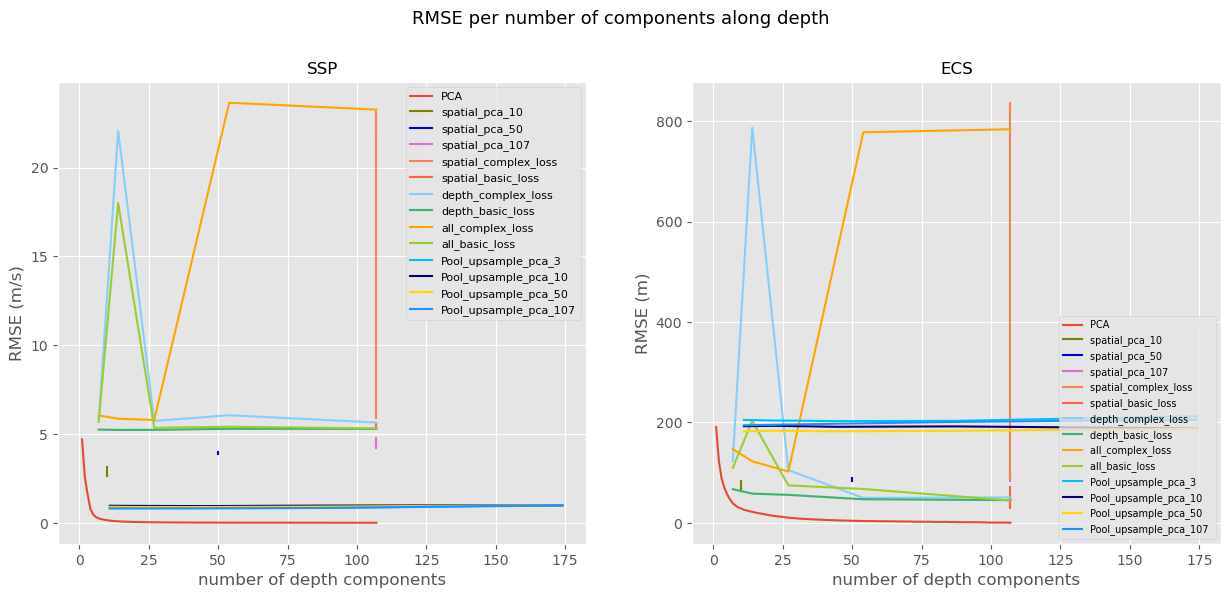

In [ ]:
pickle
colors = ['olive', 'mediumblue', 'orchid', 'coral',
          'tomato','lightskyblue', 'mediumseagreen',
          'orange','yellowgreen', 'deepskyblue', 'navy', 
          'gold', 'dodgerblue', 'royalblue', 
          ]

fig,axs = plt.subplots(1,2,figsize=(15,6))

if not norm:
    axs[0].plot(pca_ssp_rmse_dict.keys(),pca_ssp_rmse_dict.values(), label = "PCA")
    axs[1].plot(pca_ecs_rmse_dict.keys(),pca_ecs_rmse_dict.values(), label = "PCA")

i = 0

for model in components_sorted_ae_rmse_dict["SSP"].keys():
    
    print(i)
    
    
    if len(components_sorted_ae_rmse_dict["SSP"][model][0]) == 1:
        
        print(model)
        
        axs[0].scatter(components_sorted_ae_rmse_dict["SSP"][model][0], components_sorted_ae_rmse_dict["SSP"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        axs[0].hlines(components_sorted_ae_rmse_dict["SSP"][model][1], xmin=0, xmax=components_sorted_ae_rmse_dict["SSP"][model][0], colors=colors[i], linestyles='dashed')
        axs[0].vlines(components_sorted_ae_rmse_dict["SSP"][model][0], ymin=0, ymax=components_sorted_ae_rmse_dict["SSP"][model][1], colors=colors[i], linestyles='dashed')        

        axs[1].scatter(components_sorted_ae_rmse_dict["ECS"][model][0], components_sorted_ae_rmse_dict["ECS"][model][1], color=colors[i], marker='x', s=80, label = f"{model}, explicit model")  # s adjusts the cross size
        axs[1].hlines(components_sorted_ae_rmse_dict["ECS"][model][1], xmin=0, xmax=components_sorted_ae_rmse_dict["ECS"][model][0], colors=colors[i], linestyles='dashed')
        axs[1].vlines(components_sorted_ae_rmse_dict["ECS"][model][0], ymin=0, ymax=components_sorted_ae_rmse_dict["ECS"][model][1], colors=colors[i], linestyles='dashed')    
        
        i = i+1     
        
    

            
        if filtering:
            
            axs[0].scatter(components_sorted_ae_rmse_dict["Filtered SSP"][model][0], components_sorted_ae_rmse_dict["Filtered SSP"][model][1], color=colors[i], marker='x', s=80, label = f"{model} filtered, kernel={best_median_kernel}")  # s adjusts the cross size
            axs[0].hlines(components_sorted_ae_rmse_dict["Filtered SSP"][model][1], xmin=0, xmax=components_sorted_ae_rmse_dict["Filtered SSP"][model][0], colors=colors[i], linestyles='dashed')
            axs[0].vlines(components_sorted_ae_rmse_dict["Filtered SSP"][model][0], ymin=0, ymax=components_sorted_ae_rmse_dict["Filtered SSP"][model][1], colors=colors[i], linestyles='dashed')        

            axs[1].scatter(components_sorted_ae_rmse_dict["Filtered ECS"][model][0], components_sorted_ae_rmse_dict["Filtered ECS"][model][1], color=colors[i+2], marker='x', s=80, label = f"{model}, filtered, kernel={best_median_kernel}")  # s adjusts the cross size
            axs[1].hlines(components_sorted_ae_rmse_dict["Filtered ECS"][model][1], xmin=0, xmax=components_sorted_ae_rmse_dict["Filtered ECS"][model][0], colors=colors[i],linestyles='dashed')
            axs[1].vlines(components_sorted_ae_rmse_dict["Filtered ECS"][model][0], ymin=0, ymax=components_sorted_ae_rmse_dict["Filtered ECS"][model][1], colors=colors[i],linestyles='dashed')  
            
            i=i+1
               
             
    
    else:

        axs[0].plot(components_sorted_ae_rmse_dict["SSP"][model][0],components_sorted_ae_rmse_dict["SSP"][model][1], c = colors[i], label = f"{model}")
        
        axs[1].plot(components_sorted_ae_rmse_dict["ECS"][model][0], components_sorted_ae_rmse_dict["ECS"][model][1], c = colors[i], label = f"{model} ")

        i=i+1
        
        if filtering:
                 
            axs[0].plot(components_sorted_ae_rmse_dict["Filtered SSP"][model][0],components_sorted_ae_rmse_dict["Filtered SSP"][model][1], c = colors[i], label = f"{model} filtered, kernel={best_median_kernel}")
            axs[1].plot(components_sorted_ae_rmse_dict["Filtered ECS"][model][0],components_sorted_ae_rmse_dict["Filtered ECS"][model][1], c = colors[i], label = f"{model}, filtered: kernel={best_median_kernel}")
            
            i=i+1
            




if norm:
    axs[0].set_ylabel("RMSE (normalized)")  
else:    
    axs[0].set_ylabel("RMSE (m/s)")  

axs[0].set_title("SSP", fontsize = 12) 
axs[0].legend(loc = "upper right", prop={'size': 8})    
    
if norm: 
    axs[1].set_ylabel("RMSE")  
    axs[1].set_title("First max",fontsize = 12)  
else:   
    axs[1].set_ylabel("RMSE (m)")  
    axs[1].set_title("ECS",fontsize = 12)  


axs[1].legend(loc = "lower right", prop={'size': 7})
        
for ax in axs:
    ax.set_xlabel("number of depth components")
    


    
fig_title = f"RMSE per number of components along depth"
fig.suptitle(fig_title, fontsize = 13, y = 1.0)

if save_fig:
        
    save_name = fig_title.replace(" ", "_").replace(",","").replace("\n","_").replace(":","")
    
    save_name = save_name + f"_normalized_{norm}"
    
    if filtering:
        save_name = save_name + f"_median_filter_kernel_{best_median_kernel}"
    
    if ecs_max:
        save_name = save_name + f"_ecs_max"
        
    plt.savefig(f"imgs/{save_name}.png", dpi=300, bbox_inches='tight')

In [ ]:
pca_cr_list = [107/i for i in range(1,108)]

cr_sorted_ae_rmse_dict = {"SSP":{},
                       "ECS":{},
                       "Filtered SSP": {},
                       "Filtered ECS": {},
                       "ECS max": {},
                       "Filtered ECS max": {}}

for model in ae_rmse_dict["SSP"].keys():
    
    cr_key_dict = {test_ssp_tens.numel()/key.numel(): key for key in ae_rmse_dict["SSP"][model].keys()}
    sorted_cr_key = sorted(cr_key_dict.keys())
    
    # sorted_keys = sorted(ae_rmse_dict["SSP"][model].keys(), key=lambda x: x[2])
    # sorted_components = [key[2] for key in sorted_keys]
    cr_sorted_ae_rmse_dict["SSP"][model] = (sorted_cr_key, [ae_rmse_dict["SSP"][model][cr_key_dict[key]] for key in sorted_cr_key])
    cr_sorted_ae_rmse_dict["ECS"][model] = (sorted_cr_key, [ae_rmse_dict["ECS"][model][cr_key_dict[key]] for key in sorted_cr_key])
     
    if filtering:
        cr_sorted_ae_rmse_dict["Filtered SSP"][model] = (sorted_cr_key, [ae_rmse_dict["Filtered SSP"][model][cr_key_dict[key]]  for key in sorted_cr_key])
        cr_sorted_ae_rmse_dict["Filtered ECS"][model] = (sorted_cr_key, [ae_rmse_dict["Filtered ECS"][model][cr_key_dict[key]]  for key in sorted_cr_key])
        


0
1
2
3
4
5
6
7
8
9
10
11
12


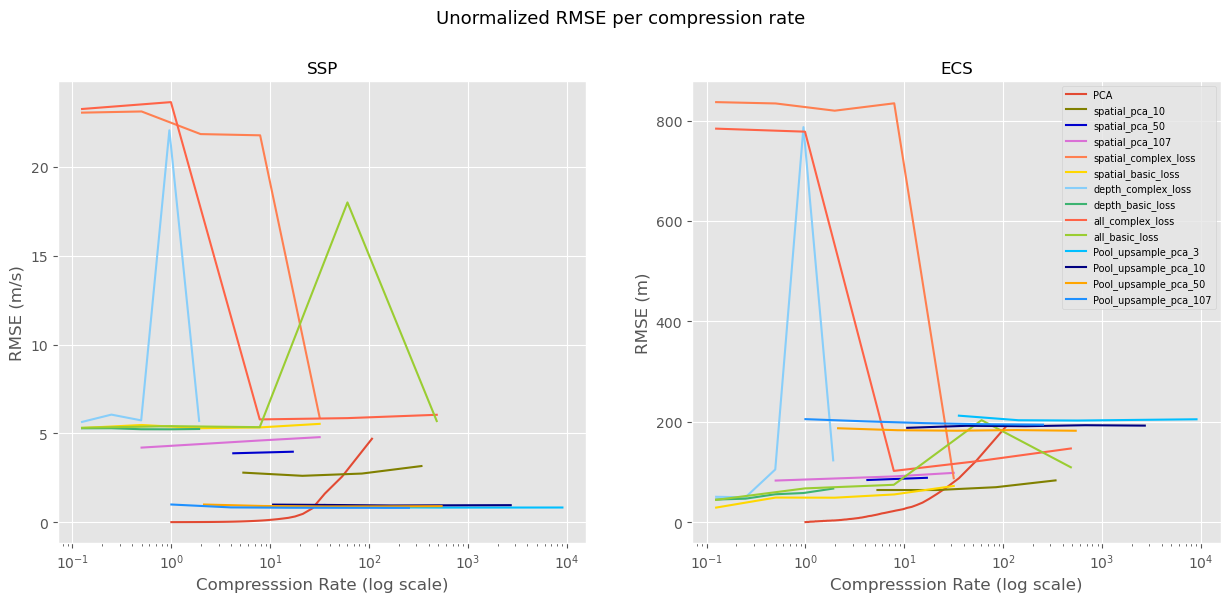

In [ ]:
ecs_max = False
filtering = False

colors = ['olive', 'mediumblue', 'orchid', 'coral',
            'gold','lightskyblue', 'mediumseagreen',
            'tomato','yellowgreen', 'deepskyblue', 'navy', 
            'orange', 'dodgerblue', 'royalblue', 
            ]

fig,axs = plt.subplots(1,2,figsize=(15,6))

if not norm:
    axs[0].plot(pca_cr_list, pca_ssp_rmse_dict.values(), label = "PCA")
    axs[1].plot(pca_cr_list,pca_ecs_rmse_dict.values(), label = "PCA")

i = 0

for model in cr_sorted_ae_rmse_dict["SSP"].keys():
    
    print(i)
    
    
    if len(cr_sorted_ae_rmse_dict["SSP"][model][0]) == 1:
        
        print(model)
        
        axs[0].scatter(cr_sorted_ae_rmse_dict["SSP"][model][0], cr_sorted_ae_rmse_dict["SSP"][model][1], color=colors[i], marker='x', s=80, label = f"{model}")  # s adjusts the cross size
        axs[0].hlines(cr_sorted_ae_rmse_dict["SSP"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["SSP"][model][0], colors=colors[i], linestyles='dashed')
        axs[0].vlines(cr_sorted_ae_rmse_dict["SSP"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["SSP"][model][1], colors=colors[i], linestyles='dashed')        

        axs[1].scatter(cr_sorted_ae_rmse_dict["ECS"][model][0], cr_sorted_ae_rmse_dict["ECS"][model][1], color=colors[i], marker='x', s=80, label = f"{model}, explicit model")  # s adjusts the cross size
        axs[1].hlines(cr_sorted_ae_rmse_dict["ECS"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["ECS"][model][0], colors=colors[i], linestyles='dashed')
        axs[1].vlines(cr_sorted_ae_rmse_dict["ECS"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["ECS"][model][1], colors=colors[i], linestyles='dashed')    
        
        i=i+1    
        
            
        if filtering:
            
            axs[0].scatter(cr_sorted_ae_rmse_dict["Filtered SSP"][model][0], cr_sorted_ae_rmse_dict["Filtered SSP"][model][1], color=colors[i], marker='x', s=80, label = f"{model} filtered, kernel={best_median_kernel}")  # s adjusts the cross size
            axs[0].hlines(cr_sorted_ae_rmse_dict["Filtered SSP"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["Filtered SSP"][model][0], colors=colors[i], linestyles='dashed')
            axs[0].vlines(cr_sorted_ae_rmse_dict["Filtered SSP"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["Filtered SSP"][model][1], colors=colors[i], linestyles='dashed')        

            axs[1].scatter(cr_sorted_ae_rmse_dict["Filtered ECS"][model][0], cr_sorted_ae_rmse_dict["Filtered ECS"][model][1], color=colors[i], marker='x', s=80, label = f"{model}, filtered, kernel={best_median_kernel}")  # s adjusts the cross size
            axs[1].hlines(cr_sorted_ae_rmse_dict["Filtered ECS"][model][1], xmin=0, xmax=cr_sorted_ae_rmse_dict["Filtered ECS"][model][0], colors=colors[i],linestyles='dashed')
            axs[1].vlines(cr_sorted_ae_rmse_dict["Filtered ECS"][model][0], ymin=0, ymax=cr_sorted_ae_rmse_dict["Filtered ECS"][model][1], colors=colors[i],linestyles='dashed')  
            
            i=i+1
            

    
    else:

        axs[0].plot(cr_sorted_ae_rmse_dict["SSP"][model][0],cr_sorted_ae_rmse_dict["SSP"][model][1], c = colors[i], label = f"{model}")
        
        axs[1].plot(cr_sorted_ae_rmse_dict["ECS"][model][0], cr_sorted_ae_rmse_dict["ECS"][model][1], c = colors[i], label = f"{model}")

        i=i+1
        
        
        if ecs_max:
            axs[1].plot(cr_sorted_ae_rmse_dict["ECS max"][model][0], cr_sorted_ae_rmse_dict["ECS max"][model][1], c = colors[i], label = f"{model} max algo")

            i=i+1
            
            
        if filtering:
            axs[0].plot(cr_sorted_ae_rmse_dict["Filtered SSP"][model][0],cr_sorted_ae_rmse_dict["Filtered SSP"][model][1], c = colors[i], label = f"{model} filtered, kernel={best_median_kernel}")
            axs[1].plot(cr_sorted_ae_rmse_dict["Filtered ECS"][model][0],cr_sorted_ae_rmse_dict["Filtered ECS"][model][1], c = colors[i], label = f"{model}, filtered: kernel={best_median_kernel}")
            
            i=i+1
            
            if ecs_max:
                axs[1].plot(cr_sorted_ae_rmse_dict["Filtered ECS max"][model][0],cr_sorted_ae_rmse_dict["Filtered ECS max"][model][1], c = colors[i], label = f"{model} max algo, filtered: kernel={best_median_kernel}")
                
                i=i+1
                




axs[0].set_title("SSP", fontsize = 12) 
#axs[0].legend(loc = "upper left", prop={'size': 8})    


if norm: 
    axs[0].set_ylabel("RMSE")  
    axs[1].set_ylabel("RMSE")  
    axs[1].set_title("First max",fontsize = 12)  
    fig_title = f"Normalized RMSE per compression rate"
    
else:   
    axs[0].set_ylabel("RMSE (m/s)")  
    axs[1].set_ylabel("RMSE (m)")  
    axs[1].set_title("ECS",fontsize = 12)  
    fig_title = f"Unormalized RMSE per compression rate"


axs[1].legend(loc = "best", prop={'size': 7})
        
for ax in axs:

    ax.set_xlabel("Compresssion Rate (log scale)")
    ax.set_xscale("log")
    


    

fig.suptitle(fig_title, fontsize = 13, y = 1.0)

if save_fig:
        
    save_name = fig_title.replace(" ", "_").replace(",","").replace("\n","_").replace(":","")
    
    save_name = save_name + f"_normalized_{norm}"
    
    if filtering:
        save_name = save_name + f"_median_filter_kernel_{best_median_kernel}"
    
    if ecs_max:
        save_name = save_name + f"_ecs_max"
        
    plt.savefig(f"imgs/{save_name}.png", dpi=300, bbox_inches='tight')